## Análisis Morfológico

Consideramos la operación de apertura morfolófica en una imágen binaria, como pasar un objeto (elemento estructurante) sobre el area blanca de la imágen y sólo mantener en blanco las partes de la imágen en donde el elemento fue capaz de pasar. Es claro que una operación como esta es invariante a translación, ya que no importa en que parte de la imágen esté el area blanca. Consideremos la siguiente imágen como ejemplo

In [2]:
%run radiomorpho.py
import numpy as np
import skimage.morphology as morpho
from astropy.io import fits
import skimage as sk
from astropy.io import fits
import skimage as sk
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
dirs = ('101first_fit', '101nvss_fit')
files, images = readImagesFromDirs(dirs) #cargamos todas las imagenes

error reading image 101first_fit/J0331-2849_z1.0890p_1.09Mpc.fi.fit or 101nvss_fit/J0331-2849_z1.0890p_1.09Mpc.nv.fit


In [3]:
img = images[:,2][18] > .18

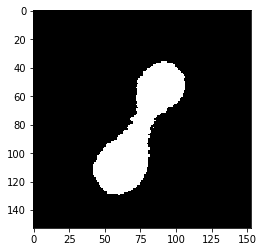

In [4]:
plt.imshow(img, cmap='gray'); plt.show()

En esta imágen un elemento suficientemente grande no podría pasar por el pequeño segmento que une a los dos lobulos en la imágen. El area gris representa el area que se perdería despues de hacer la apertura morfológica. Esta perdida de area nos ayuda a entender la forma de la imágen, ya que nos brinda información sobre los detalles finos de la imágen. Si usamos multiples elementos de multiples tamaños podemos obtener una representación vectorial de la imágen en base a las perdidads de area. Un aspecto importante es que si el elemento es circular, la operación de apertura morfolófica es invariante a rotación.

In [76]:
def plot_opening_example(img, n, sz):
    i = 0
    f, ax = plt.subplots(n, 3, figsize=(16, 2.8*n))
    ax[0][0].set_title('Elemento')
    ax[0][1].set_title('Original')
    ax[0][2].set_title('Apertura')
    for i in range(n):
        d1 = morpho.disk( (i+1) * sz)
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        ax[i][2].axis('off')
        ax[i][0].imshow(np.pad(d1, 60, 'constant'), cmap='gray')
        ax[i][1].imshow(img, cmap='gray')
        ax[i][2].imshow(img.astype(float) + morpho.opening(img, d1), cmap='gray')
    plt.show()

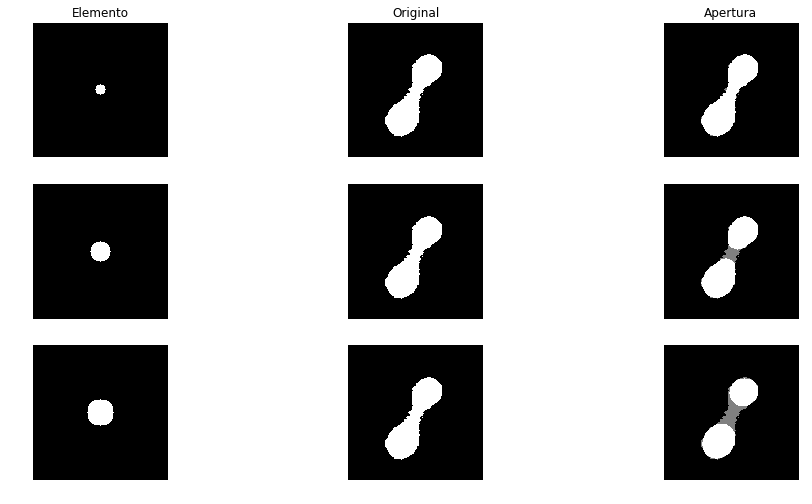

In [77]:
plot_opening_example(img, 3, 5)

Esta perdida de area nos ayuda a entender la forma de la imágen, ya que nos brinda información sobre los detalles finos de la imágen. Si usamos multiples elementos de multiples tamaños podemos obtener una representación vectorial de la imágen en base a las perdidads de area. Un aspecto importante es que si el elemento es circular, la operación de apertura morfolófica es invariante a rotación.

Para evitar umbralizados sobre la imágen FITS original, podemos considerar la apertura morfolófica sobre una imágen a escala de grises. Para entender como funciona es más facil ver la imágen a escala de grises como una superficie 3D

In [85]:
f2 = images[:,1][18]
f1 = images[:,0][18]
scale_fac = (f1.shape[0]/f2.shape[0] , f1.shape[1]/f2.shape[1])
img = sk.transform.rescale(f2, scale_fac, mode='reflect', multichannel=False, anti_aliasing=True)
X = np.arange(-1, 1, 2/img.shape[0])
Y = np.arange(-1, 1, 2/img.shape[1])
X, Y = np.meshgrid(X, Y)

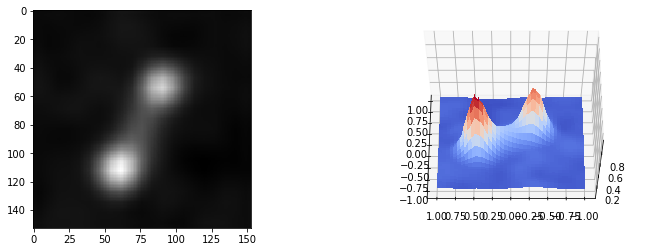

In [97]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(60, 180)
surf = ax.plot_surface(X, Y, img, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax = fig.add_subplot(1, 2, 1)
p = ax.imshow(img, cmap='gray')

La apertura morfolófica en este caso equivaldría a pasar un disco y eliminar los picos en los cuales no puede pasar. Esto sería como meter una moneda en un cono y cortar el pico del cono hasta donde quedó atorada la moneda.

Usando la apertura morfológica en escala de grises, con multiples discos de radios distintos, sobre las imágenes NVSS podemos generar vectores con información, invariante a rotación y translación, de las imágenes. Consideremos los casos específicos de las siguientes imágenes y sus vectores representantes (graficados como curvas).

In [39]:
dt = []
for im in images:
    dt.append( get_open_close_info(im[1], 8) )
dt = np.array(dt[:])
dt = dt[:,:8]

In [50]:
def plot_example1(idx, s1, s2, w, h):
    max_v = 0
    for i in idx:
        max_v = dt[idx].max()
    print(max_v)
    fig = plt.figure(figsize=(s1, s2))
    grid = plt.GridSpec(2, 7, wspace=w, hspace=h)
    for i in range(len(idx)):
        pl1 = fig.add_subplot(grid[0, i])
        pl1.imshow(images[:, 1][idx[i]])
        pl1 = fig.add_subplot(grid[1, i])
        pl1.plot(dt[idx[i]])
        plt.ylim(0, max_v*1.05)
    pl1 = fig.add_subplot(grid[:, 5:])
    pl1.plot(dt[3])

    pl1.plot(dt[3], label=3, c = 'c')
    pl1.plot(dt[5], label=5, c = 'c', ls='--')
    pl1.plot(dt[8], label=8, c = 'g')
    pl1.plot(dt[9], label=9, c = 'g', ls='--')
    pl1.plot(dt[7], label=7, c = 'r')
    
    plt.legend()
    plt.show()

371.7172394162044


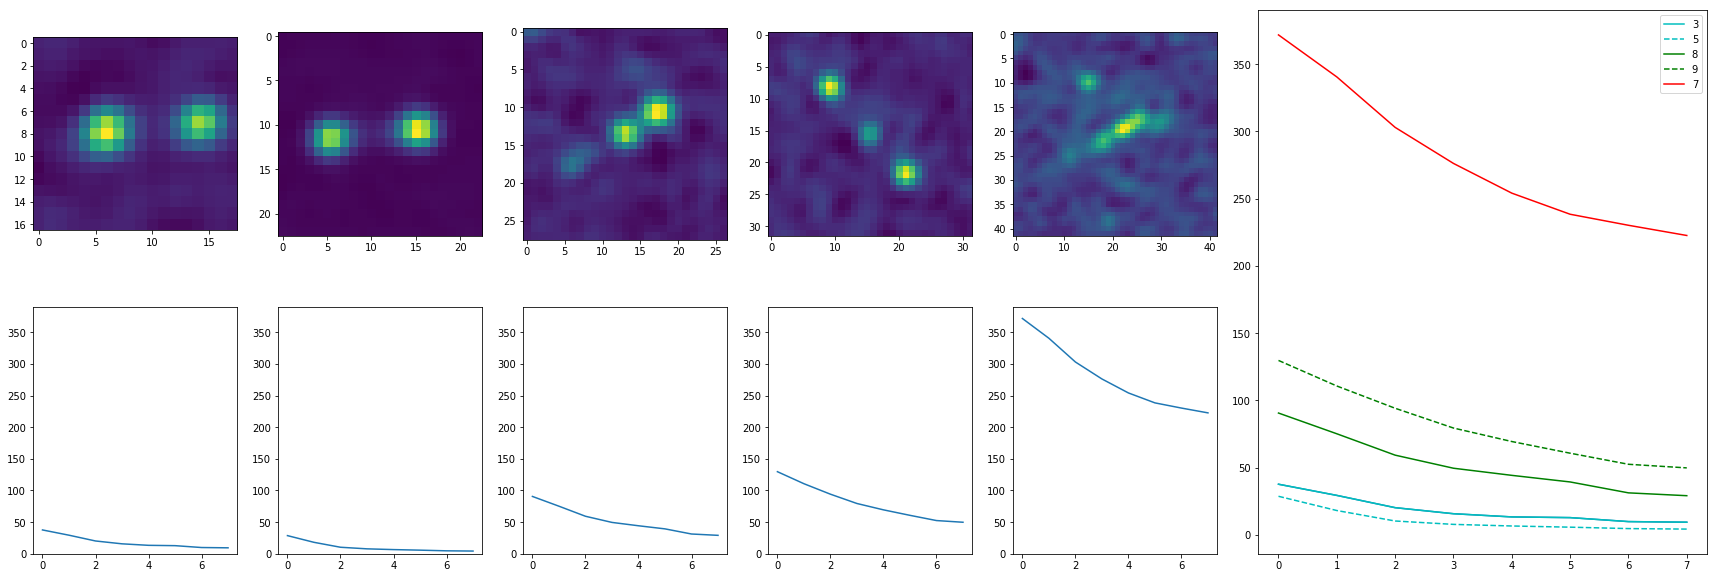

In [51]:
plot_example1([3,5,8,9,7], 30, 10, .2, .2)
#modificar escala de graficas chicas

Como podemos observar, las imágenes parecidas, tienen curvas similares. Usando esta información, podemos aplicar métodos de reducción de dimensión que nos permitan visualizar los datos en un plano.

In [205]:
from sklearn import decomposition
from sklearn.manifold import TSNE
dat = dt[:, :8]
pca = decomposition.PCA(n_components=2)
pca.fit(dat)
Y = pca.transform(dat)
xs, ys = Y[:,0] , Y[:,1]

In [187]:
class DataBrowser(object):
    """
    Click on a point to select and highlight it -- the data that
    generated the point will be shown in the lower axes.  Use the 'n'
    and 'p' keys to browse through the next and previous points
    """

    def __init__(self, fig, ax1, ax2, xs, ys):
        self.lastind = 0

        self.text = ax1.text(0.05, 0.95, 'selected: none',
                            transform=ax1.transAxes, va='top')
        self.selected, = ax1.plot([xs[0]], [ys[0]], 'o', ms=12, alpha=0.4,
                                 color='yellow', visible=False)
        self.xs = xs
        self.ys = ys
        self.fit = fig

        self.ax2 = ax2

    def onpress(self, event):
        if self.lastind is None:
            return
        if event.key not in ('n', 'p'):
            return
        if event.key == 'n':
            inc = 1
        else:
            inc = -1

        self.lastind += inc
        self.lastind = np.clip(self.lastind, 0, len(self.xs) - 1)
        self.update()

    def onpick(self, event):

        if event.artist != line:
            return True

        N = len(event.ind)
        if not N:
            return True

        # the click locations
        x = event.mouseevent.xdata
        y = event.mouseevent.ydata

        distances = np.hypot(x - self.xs[event.ind], y - self.ys[event.ind])
        indmin = distances.argmin()
        dataind = event.ind[indmin]

        self.lastind = dataind
        self.update()

    def update(self):
        if self.lastind is None:
            return

        dataind = self.lastind

        img = readNormalizedImg(files[dataind][1])
        self.ax2.cla()
        self.ax2.imshow(img, cmap='gray')

        self.selected.set_visible(True)
        self.selected.set_data(self.xs[dataind], self.ys[dataind])

        self.text.set_text('selected: {0} | {1}'.format(dataind,
            '.'.join(files[dataind][0].split('/')[1].split('.')[:-2])))
        self.fig.canvas.draw()

## Análisis de Componenetes Principales (PCA)

El PCA es un proceso de reducción de dimensión con la finalidad de extraer información util de datos de alta dimensionalidad. Buscamos direcciones de proyección informativas

![PCA_EX](pca_example.png)

Con *informativo* nos referimos a que tenga el minimo error de reconstrucción o máxima variabilidad.

PCA es muy util para visualización de datos ya que nos permite resumir nuestros datos a $\mathbb{R}^2$. Es importante tomar en cuenta que PCA es perceptible a sesgos con datos anormales. Es posible que este sea el caso ya que tenemos un dato muy alejado de los demas.

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
pca = decomposition.PCA(n_components=2)
pca.fit(dat)
Y = pca.transform(dat)
xs, ys = Y[:,0] , Y[:,1]

Explained variance ratio:  [0.99336621 0.0058117 ]


<IPython.core.display.Javascript object>


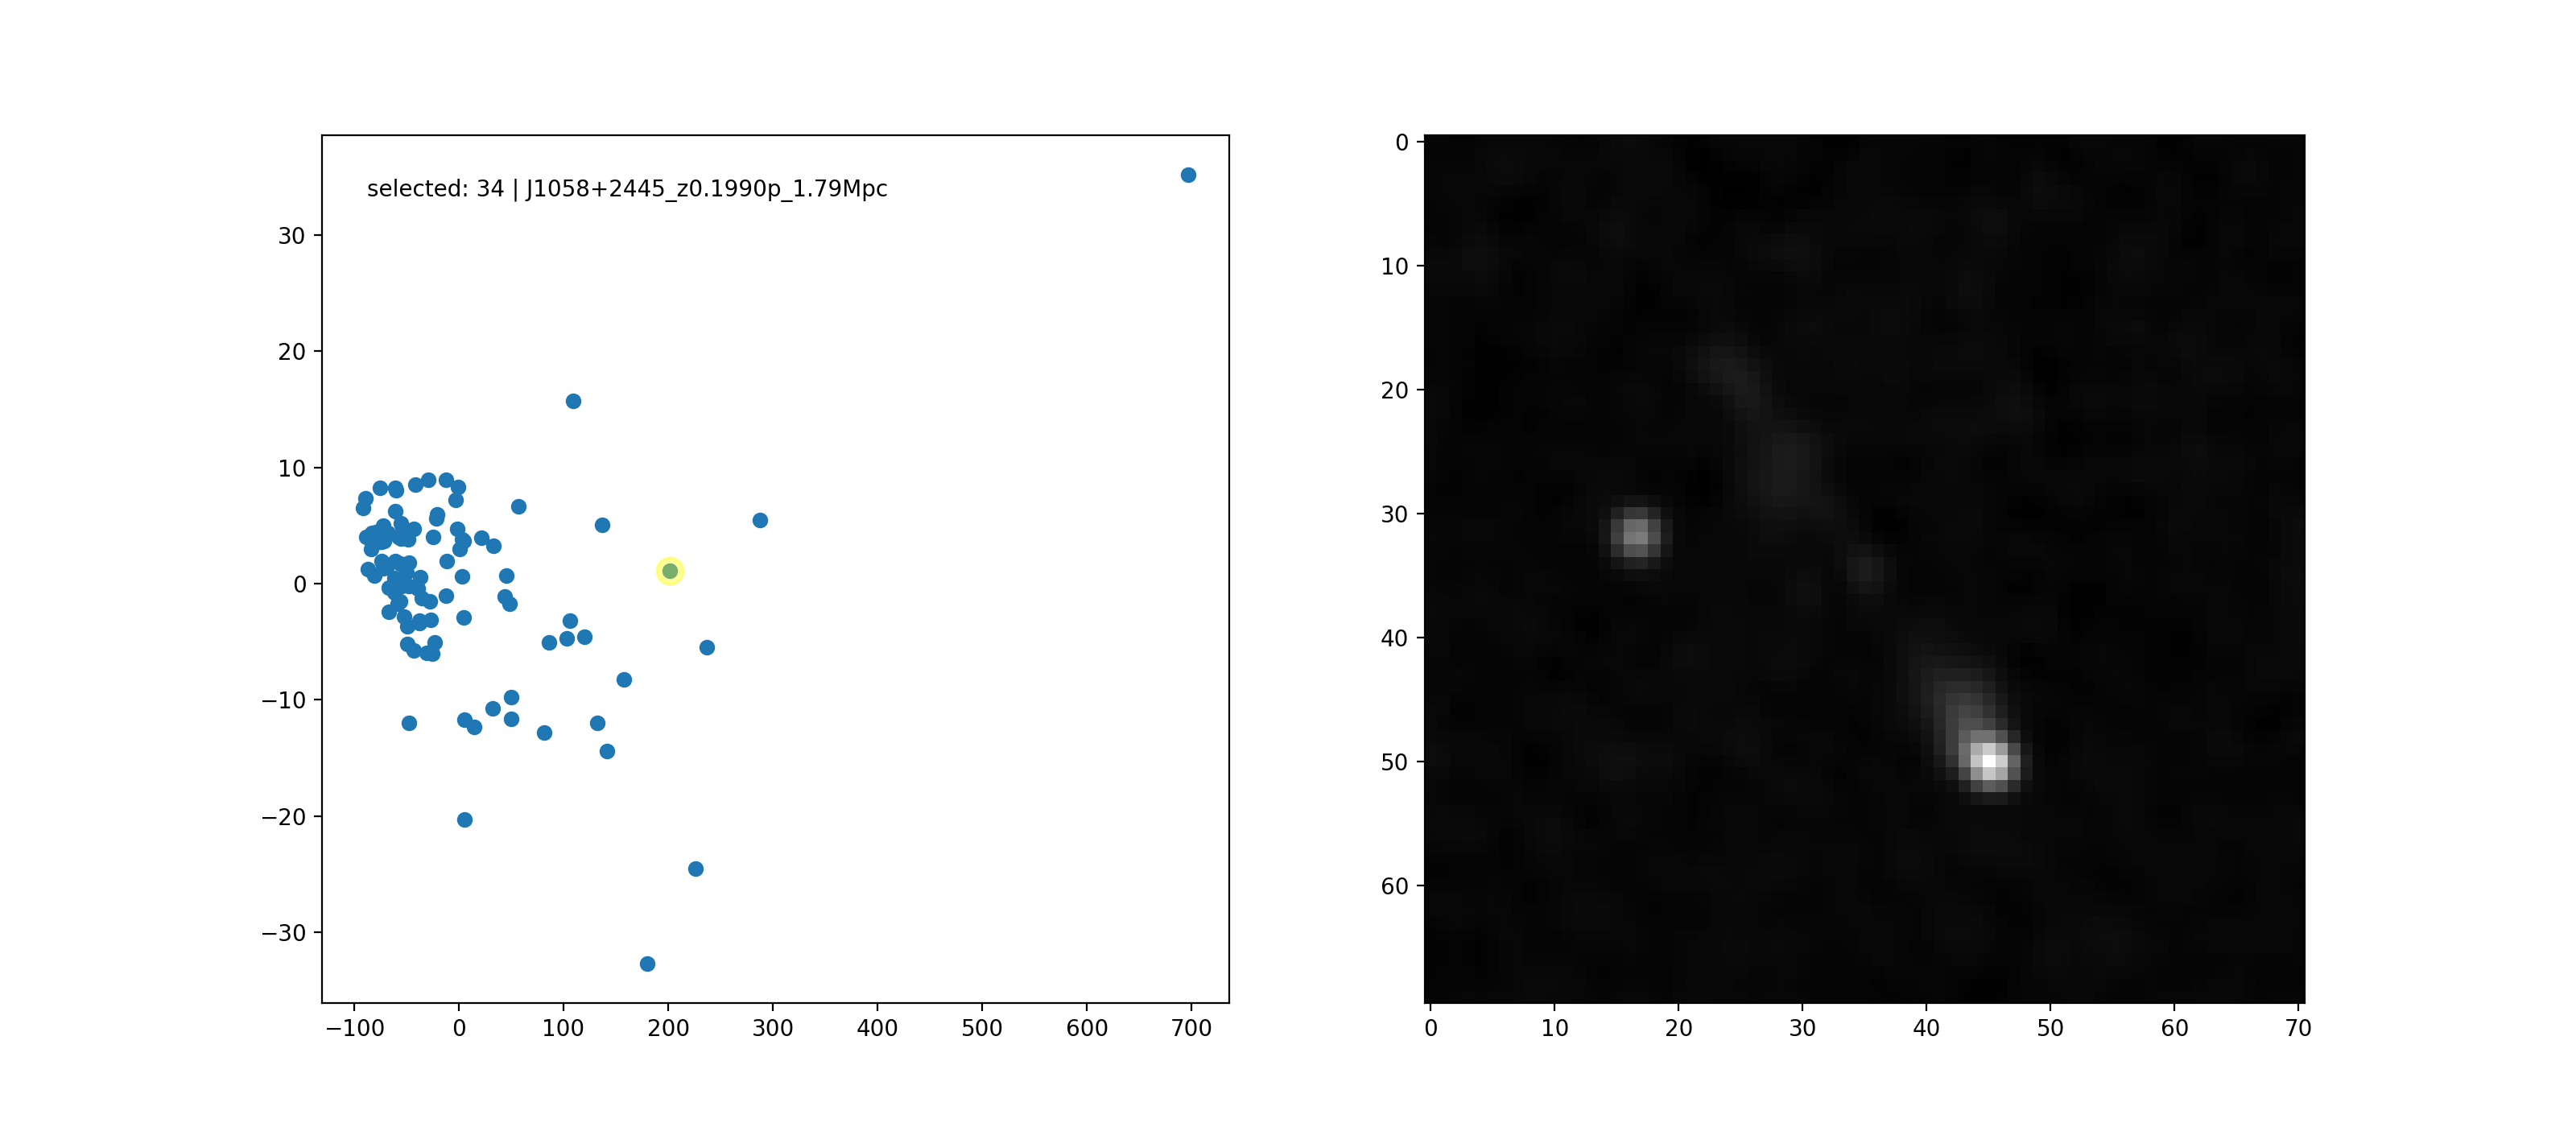

In [212]:
print("Explained variance ratio: ", pca.explained_variance_ratio_)
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 7))
line, = ax.plot(xs, ys, 'o', picker=5) ; browser = DataBrowser(fig, ax, ax2, xs, ys)
fig.canvas.mpl_connect('pick_event', browser.onpick) ; fig.canvas.mpl_connect('key_press_event', browser.onpress)
plt.show()

In [234]:
from matplotlib import offsetbox
def plot_embedding(X, Y, title=None, space = 0.04, figsize=(16, 7)):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1])

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(Y.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < space:
#                 don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            f2 = Y[i]
            scale_fac = (20/f2.shape[0] , 20/f2.shape[1])
            img = sk.transform.rescale(f2, scale_fac, mode='reflect', multichannel=False, anti_aliasing=True)
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img, cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

<IPython.core.display.Javascript object>


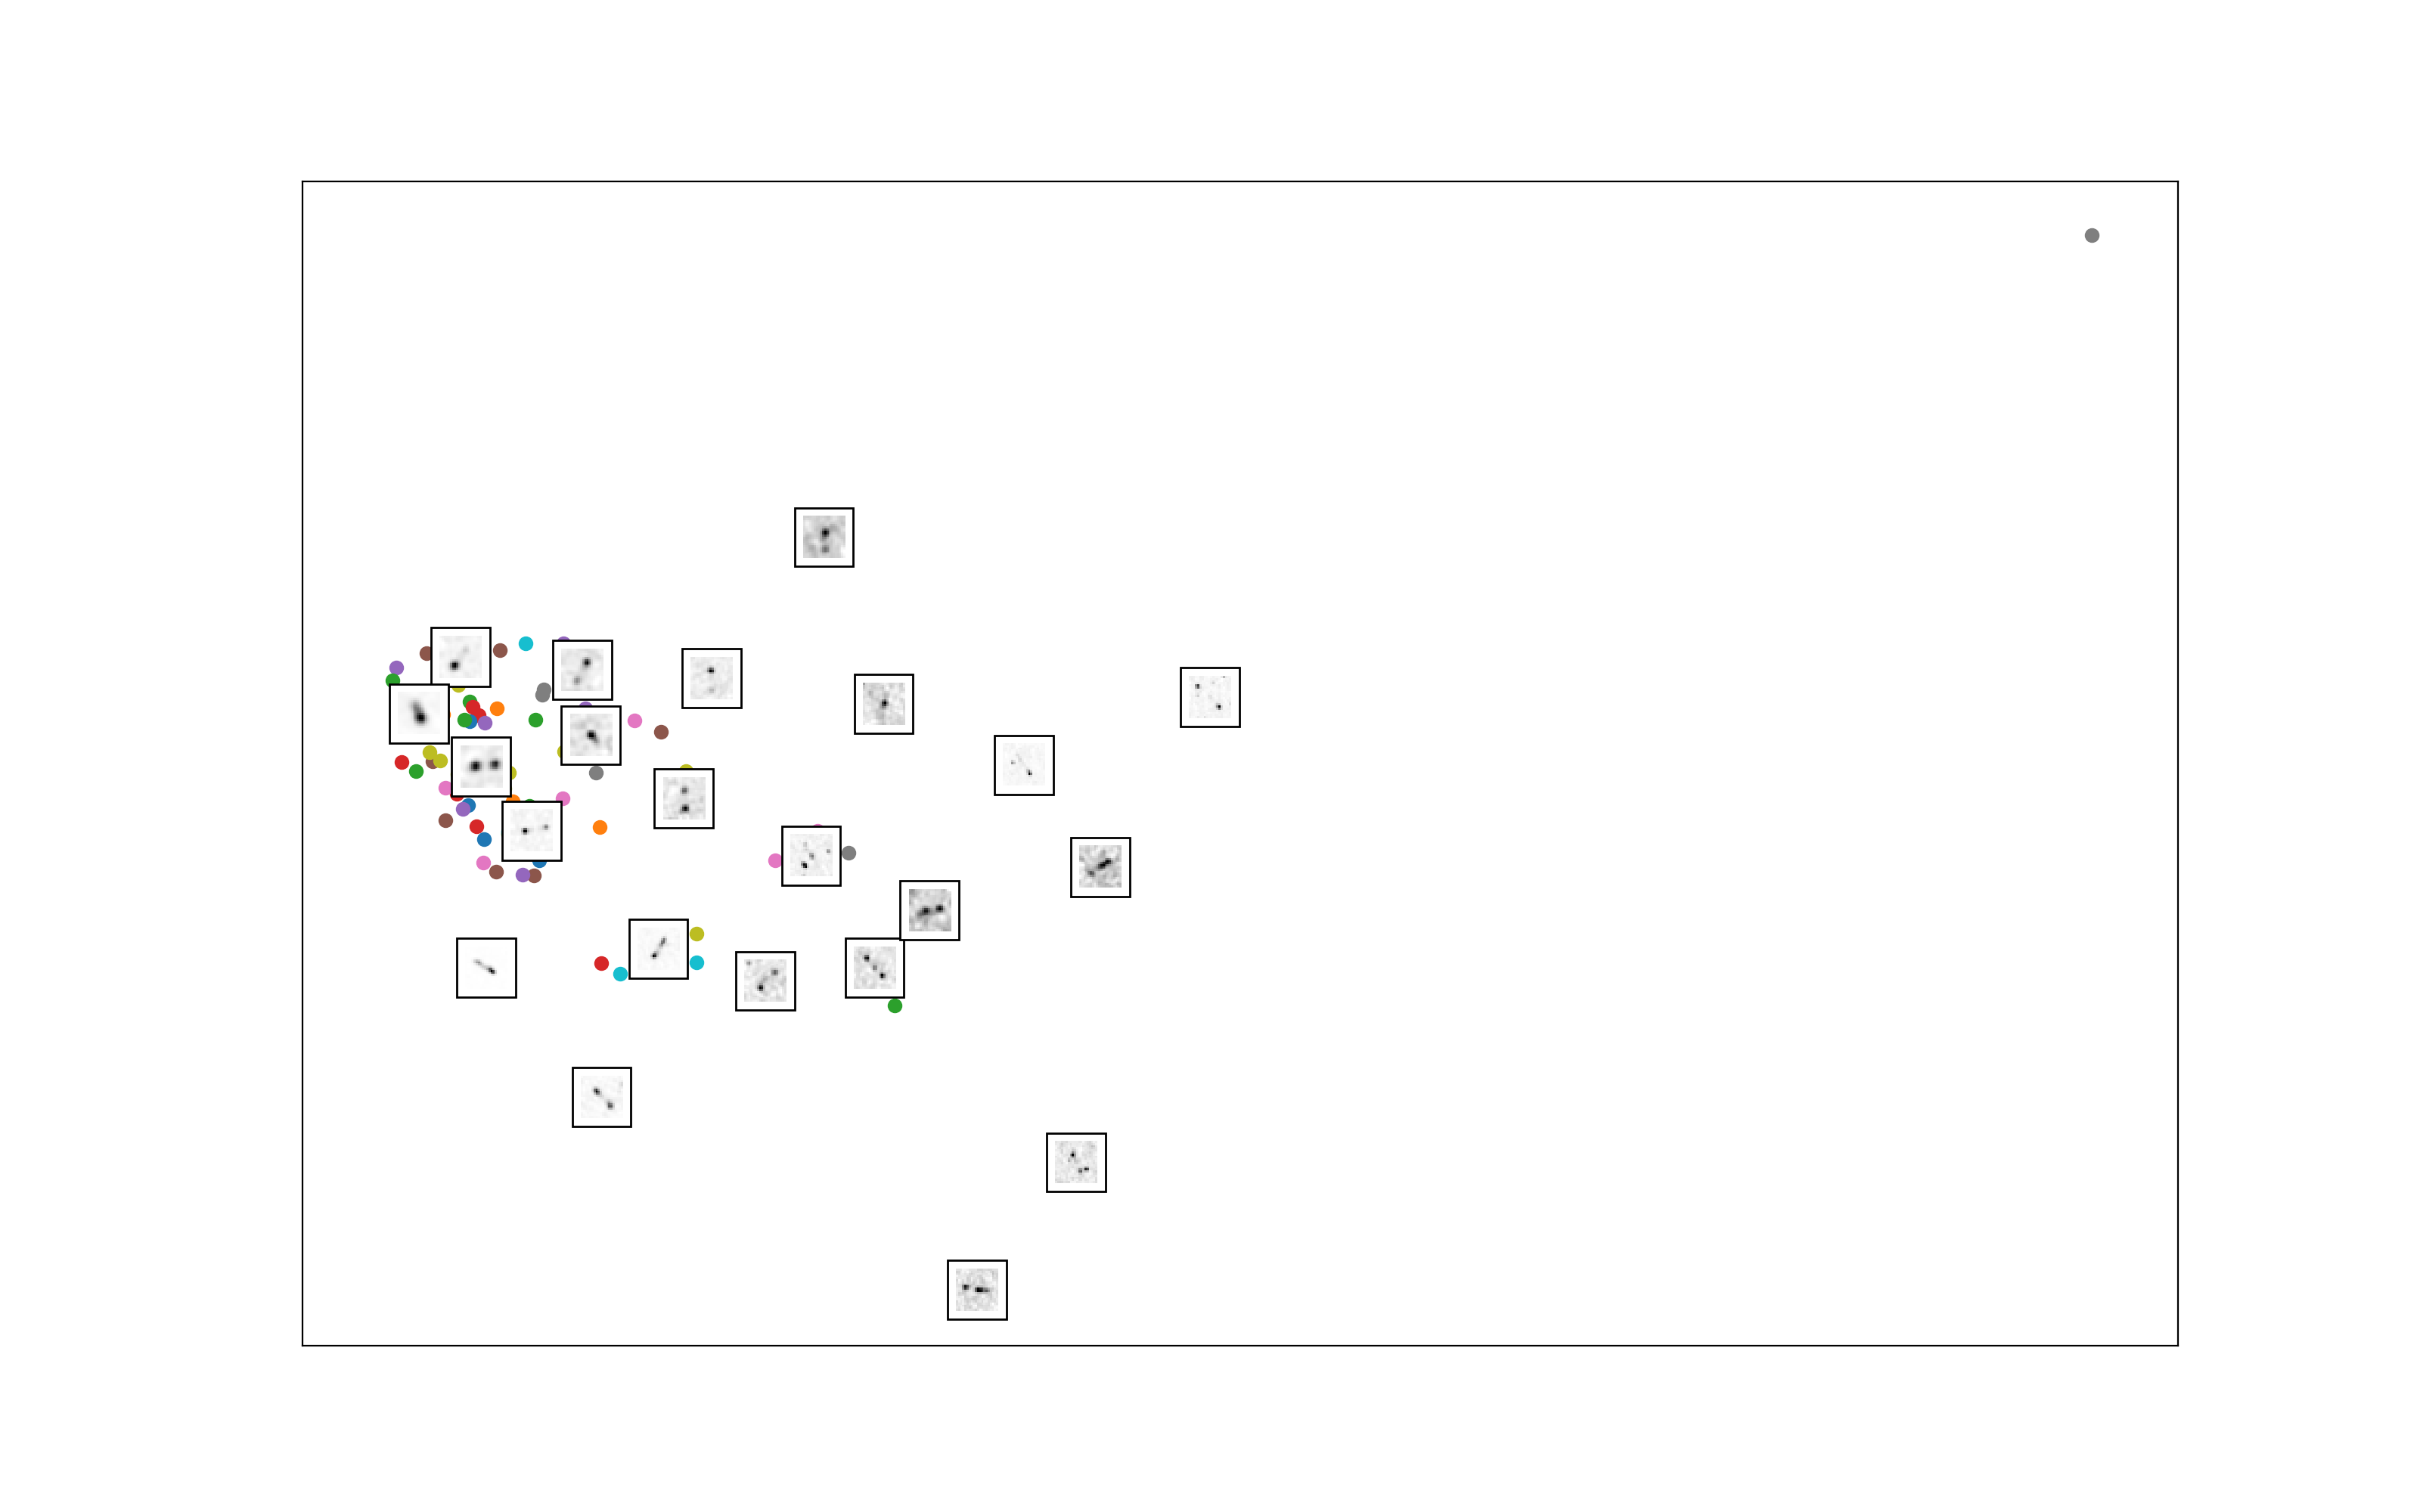

In [238]:
# %matplotlib inline
import matplotlib.pyplot as plt
plot_embedding(Y, images[:, 1] , space = 0.003, figsize=(16, 10))

### ¿Diferencias con SOM?